In [30]:
import os
import cv2
import warnings
import random
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [31]:
def load_balanced_split_dataset(cat_dir='Cat', dog_dir='Dog', image_size=(64, 64), 
                                 max_images_per_class=500, train_frac=0.8, 
                                 grayscale=False, seed=42):
    import os, cv2, numpy as np, warnings, random

    def is_image_file(filename):
        return filename.lower().endswith(('.jpg', '.jpeg'))

    def safe_read_image(path):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
                img = cv2.imread(path, flag)
                if img is not None:
                    img = cv2.resize(img, image_size)
                return img
        except:
            return None

    random.seed(seed)

    def load_class_images(directory, label):
        images = []
        for filename in os.listdir(directory):
            if not is_image_file(filename):
                continue
            path = os.path.join(directory, filename)
            img = safe_read_image(path)
            if img is not None:
                images.append((img, label))
            if len(images) >= max_images_per_class:
                break
        return images

    cats = load_class_images(cat_dir, 0)
    dogs = load_class_images(dog_dir, 1)

    if not cats or not dogs:
        raise ValueError("Недостаточно изображений в одной из папок")

    random.shuffle(cats)
    random.shuffle(dogs)

    n_cat_train = int(len(cats) * train_frac)
    n_dog_train = int(len(dogs) * train_frac)

    train = cats[:n_cat_train] + dogs[:n_dog_train]
    test  = cats[n_cat_train:] + dogs[n_dog_train:]

    if not train or not test:
        raise ValueError("Ошибка: пустой train или test набор")

    random.shuffle(train)
    random.shuffle(test)

    X_train, y_train = zip(*train) if train else ([], [])
    X_test, y_test = zip(*test) if test else ([], [])

    return (
        np.array(X_train, dtype=np.uint8),
        np.array(y_train, dtype=np.uint8),
        np.array(X_test, dtype=np.uint8),
        np.array(y_test, dtype=np.uint8)
    )


X_train, y_train, X_test, y_test = load_balanced_split_dataset(cat_dir='/kaggle/input/dog-and-cat-classification-dataset/PetImages/Cat',
                           dog_dir='/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog', grayscale=False)

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


In [32]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

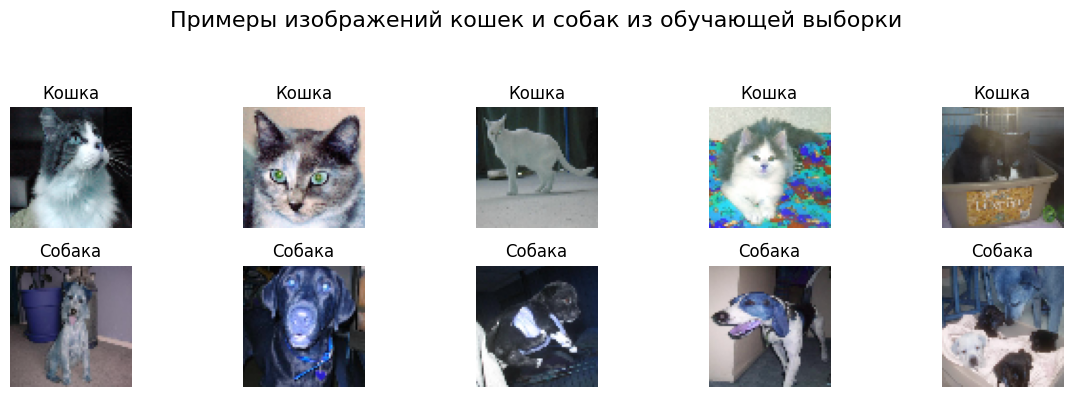

In [33]:
cat_indices = np.where(y_train == 0)[0][:5]
dog_indices = np.where(y_train == 1)[0][:5]

# Отображаем
plt.figure(figsize=(12, 4))

# Кошки
for i, idx in enumerate(cat_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title("Кошка")
    plt.axis('off')

# Собаки
for i, idx in enumerate(dog_indices):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_train[idx])
    plt.title("Собака")
    plt.axis('off')

plt.suptitle("Примеры изображений кошек и собак из обучающей выборки", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# Тренируем случайный лес (без PCA)

In [34]:
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train_flat, y_train)

# Предсказание
y_pred = clf.predict(X_test_flat)

# Метрики
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6150

Classification Report:
              precision    recall  f1-score   support

         Cat       0.61      0.64      0.62       100
         Dog       0.62      0.59      0.61       100

    accuracy                           0.61       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.62      0.61      0.61       200


Confusion Matrix:
[[64 36]
 [41 59]]


# Тренируем случайный лес (PCA)

In [35]:
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [36]:
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

# Метрики
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))


Accuracy: 0.5700

Classification Report:
              precision    recall  f1-score   support

         Cat       0.56      0.61      0.59       100
         Dog       0.58      0.53      0.55       100

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200



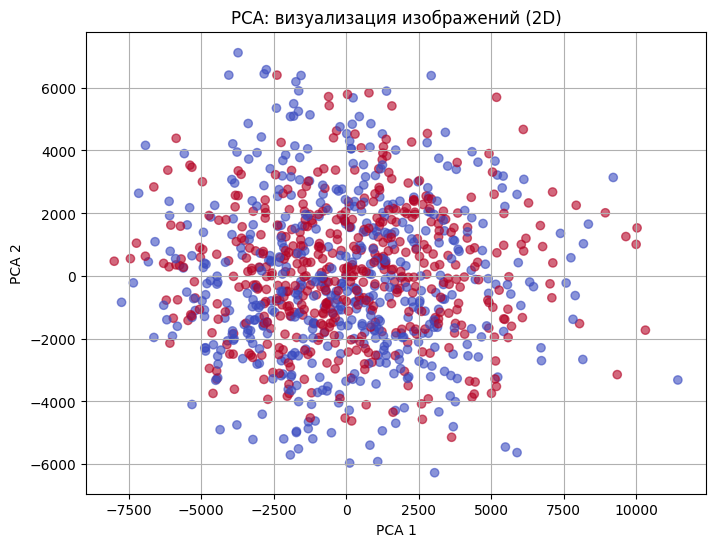

In [37]:
pca_2d = PCA(n_components=2)
X_vis = pca_2d.fit_transform(np.vstack([X_train_flat, X_test_flat]))
y_vis = np.concatenate([y_train, y_test])

plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap='coolwarm', alpha=0.6)
plt.title("PCA: визуализация изображений (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [38]:
pca_full = PCA().fit(X_train_flat)
explained_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(explained_var >= 0.90) + 1
print(f"Для объяснения 90% дисперсии требуется {n_components_90} компонент.")

Для объяснения 90% дисперсии требуется 182 компонент.


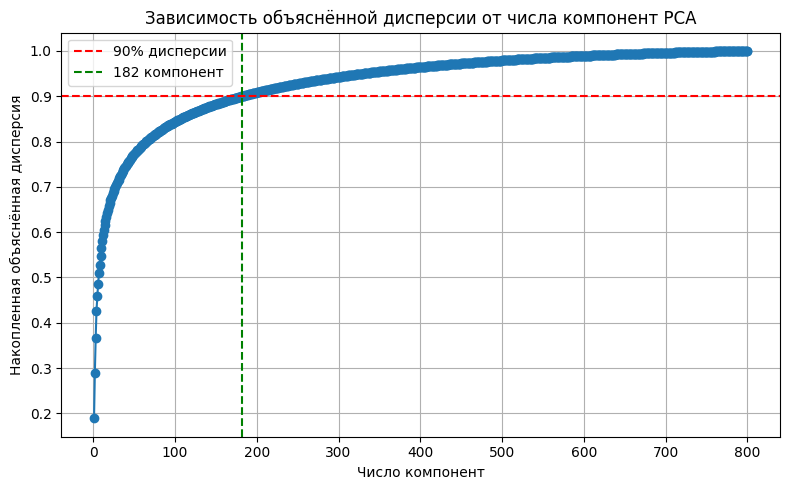

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_var) + 1), explained_var, marker='o')
plt.axhline(0.90, color='red', linestyle='--', label='90% дисперсии')
plt.axvline(n_components_90, color='green', linestyle='--', label=f'{n_components_90} компонент')
plt.xlabel("Число компонент")
plt.ylabel("Накопленная объяснённая дисперсия")
plt.title("Зависимость объяснённой дисперсии от числа компонент PCA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Тренируем 2 модели

In [40]:
max_components = min(X_train_flat.shape[0], X_train_flat.shape[1])

components_range = sorted(set(
    list(range(1, 20)) +
    list(range(20, 100, 5)) +
    list(range(100, max_components, 20))
))

components_range = [n for n in components_range if n <= max_components]
accs_rf, precs_rf, recalls_rf = [], [], []
accs_ridge, precs_ridge, recalls_ridge = [], [], []

for n in components_range:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_flat)
    X_test_pca = pca.transform(X_test_flat)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_pca, y_train)
    y_pred_rf = rf.predict(X_test_pca)

    accs_rf.append(accuracy_score(y_test, y_pred_rf))
    precs_rf.append(precision_score(y_test, y_pred_rf, average='macro'))
    recalls_rf.append(recall_score(y_test, y_pred_rf, average='macro'))

    # Ridge Classifier (линейная модель)
    ridge = RidgeClassifier(alpha=1.0)
    ridge.fit(X_train_pca, y_train)
    y_pred_ridge = ridge.predict(X_test_pca)

    accs_ridge.append(accuracy_score(y_test, y_pred_ridge))
    precs_ridge.append(precision_score(y_test, y_pred_ridge, average='macro'))
    recalls_ridge.append(recall_score(y_test, y_pred_ridge, average='macro'))

# Посмотрим на случайный лес

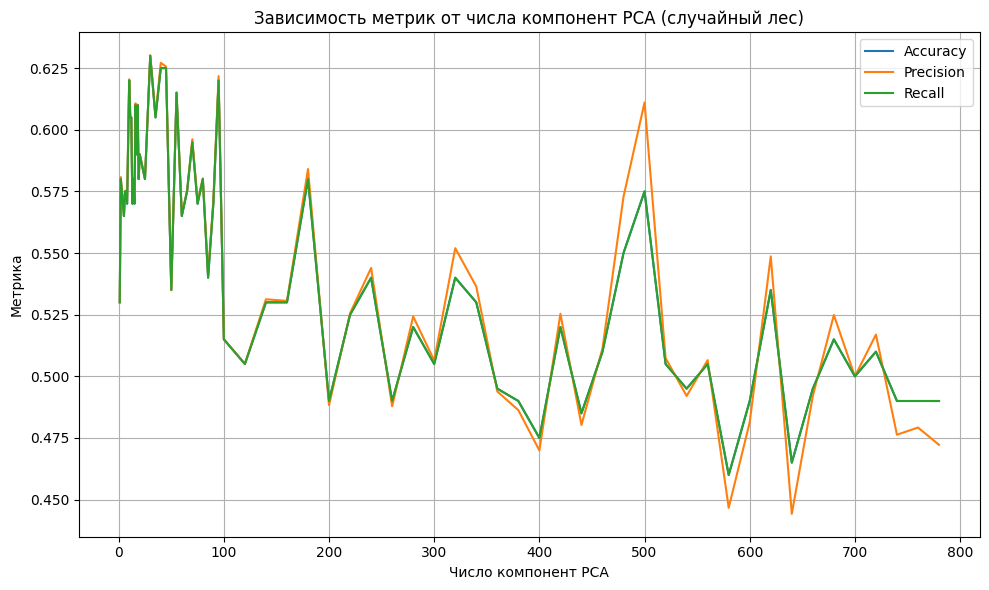

In [52]:
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(components_range, accs_rf, label='Accuracy')
plt.plot(components_range, precs_rf, label='Precision')
plt.plot(components_range, recalls_rf, label='Recall')
plt.xlabel("Число компонент PCA")
plt.ylabel("Метрика")
plt.title("Зависимость метрик от числа компонент PCA (cлучайный лес)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
best_idx = np.argmax(accs_rf)

best_n_components = components_range[best_idx]
best_accuracy = accs_rf[best_idx]

print(f"Максимальная accuracy = {best_accuracy:.4f} достигается при {best_n_components} компонентах.")

Максимальная accuracy = 0.6300 достигается при 30 компонентах.


In [43]:
pca_best = PCA(n_components=best_n_components)
pca_best.fit(X_train_flat)

PCA(n_components=30)

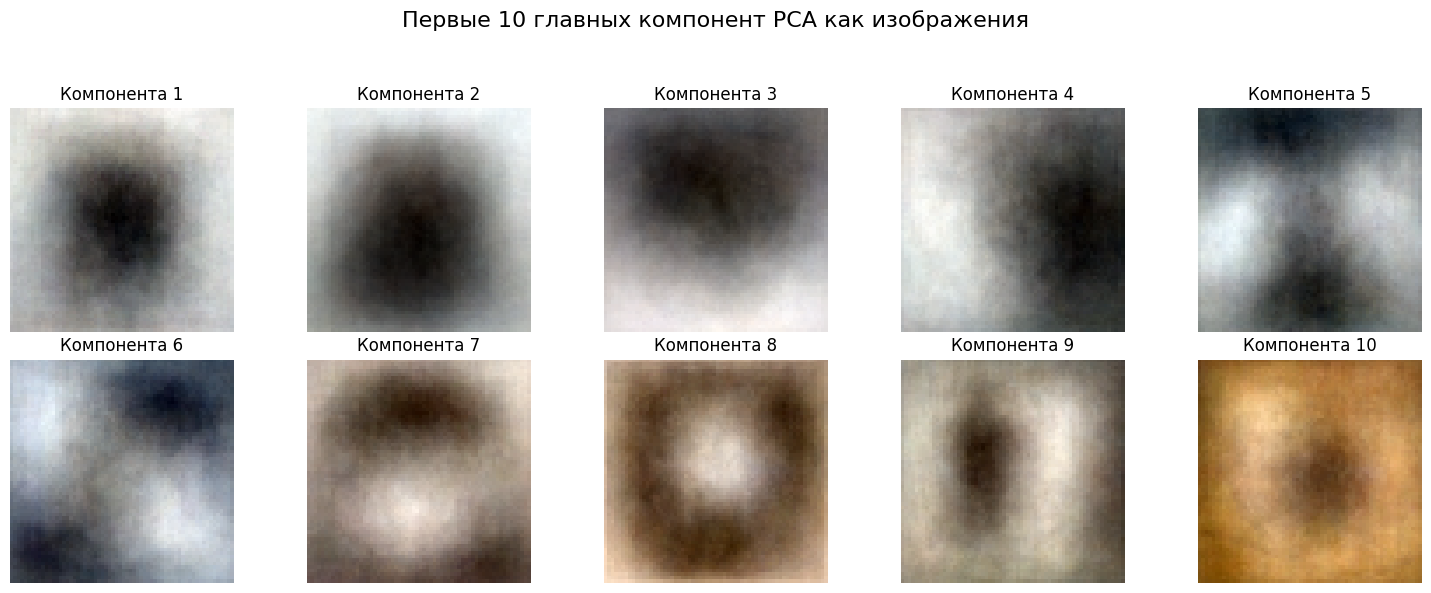

In [45]:
components = pca_best.components_
n_show = min(10, components.shape[0])

img_h, img_w, img_c = 64, 64, 3  # если grayscale=True, тогда img_c = 1
flat_img_shape = img_h * img_w * img_c

assert components.shape[1] == flat_img_shape, "Форма компонент не совпадает с размером изображений"

plt.figure(figsize=(15, 6))
for i in range(n_show):
    comp = components[i].reshape(img_h, img_w, img_c)
    
    # Нормализуем компоненту для отображения
    comp_min, comp_max = comp.min(), comp.max()
    comp_norm = (comp - comp_min) / (comp_max - comp_min + 1e-8)  # от 0 до 1

    plt.subplot(2, 5, i + 1)
    plt.imshow(comp_norm)
    plt.title(f'Компонента {i + 1}')
    plt.axis('off')

plt.suptitle("Первые 10 главных компонент PCA как изображения", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Посмотрим на линейную модель

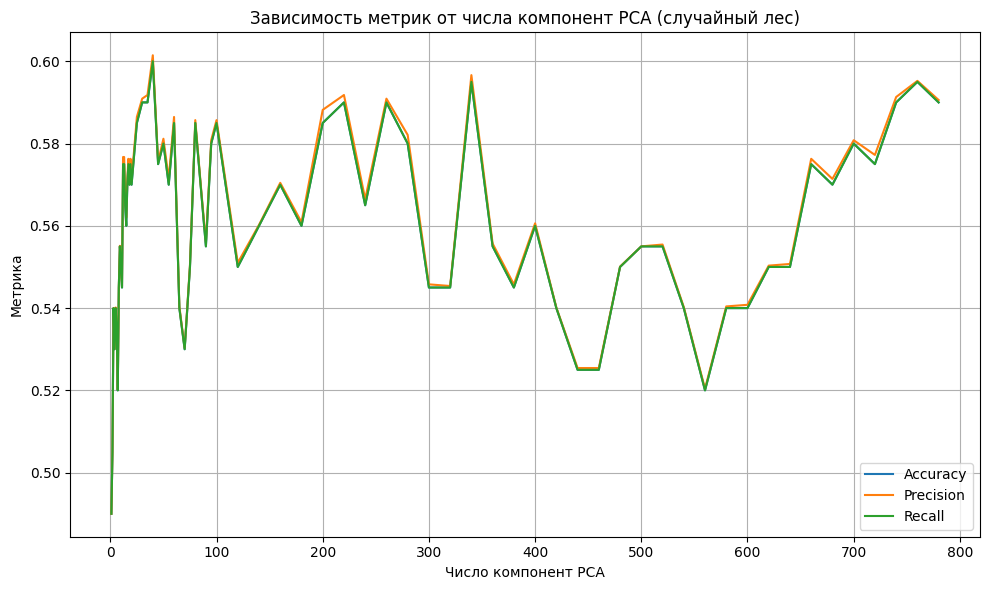

In [54]:
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(components_range, accs_ridge, label='Accuracy')
plt.plot(components_range, precs_ridge, label='Precision')
plt.plot(components_range, recalls_ridge, label='Recall')
plt.xlabel("Число компонент PCA")
plt.ylabel("Метрика")
plt.title("Зависимость метрик от числа компонент PCA (cлучайный лес)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
best_idx = np.argmax(accs_ridge)

best_n_components = components_range[best_idx]
best_accuracy = accs_ridge[best_idx]

print(f"Максимальная accuracy = {best_accuracy:.4f} достигается при {best_n_components} компонентах.")

Максимальная accuracy = 0.6000 достигается при 40 компонентах.


In [56]:
pca_best = PCA(n_components=best_n_components)
pca_best.fit(X_train_flat)

PCA(n_components=40)

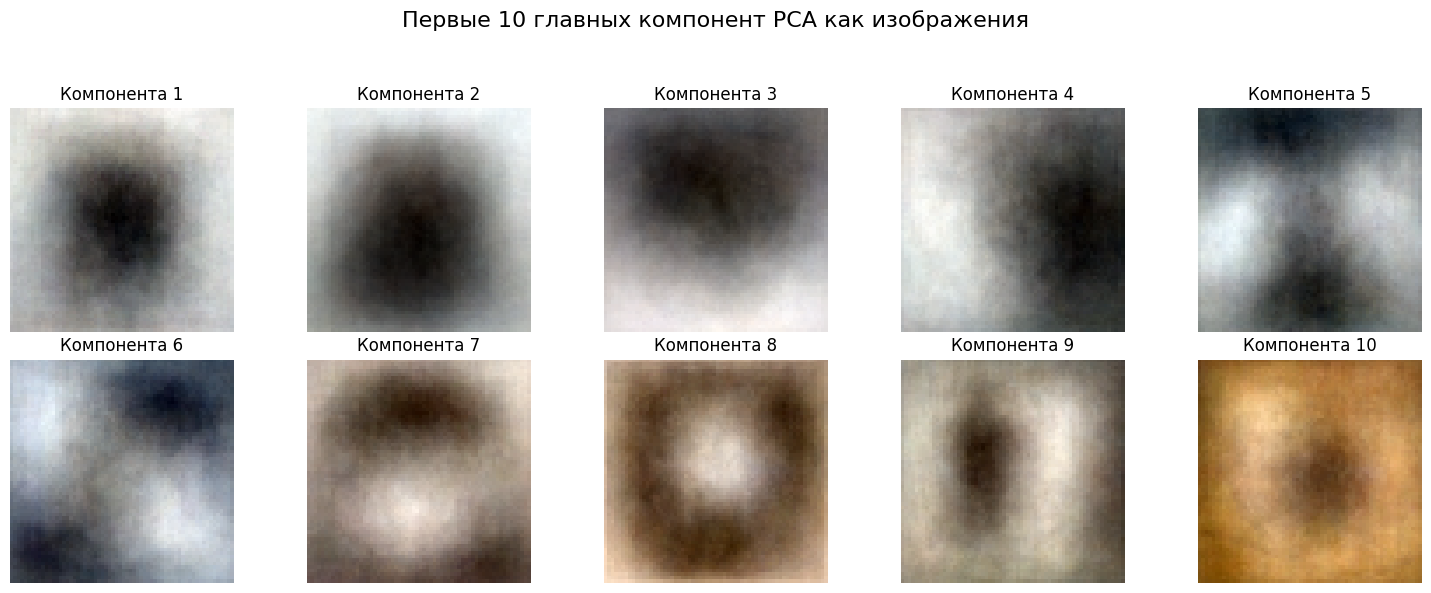

In [57]:
components = pca_best.components_
n_show = min(10, components.shape[0])

img_h, img_w, img_c = 64, 64, 3  # если grayscale=True, тогда img_c = 1
flat_img_shape = img_h * img_w * img_c

assert components.shape[1] == flat_img_shape, "Форма компонент не совпадает с размером изображений"

plt.figure(figsize=(15, 6))
for i in range(n_show):
    comp = components[i].reshape(img_h, img_w, img_c)
    
    # Нормализуем компоненту для отображения
    comp_min, comp_max = comp.min(), comp.max()
    comp_norm = (comp - comp_min) / (comp_max - comp_min + 1e-8)  # от 0 до 1

    plt.subplot(2, 5, i + 1)
    plt.imshow(comp_norm)
    plt.title(f'Компонента {i + 1}')
    plt.axis('off')

plt.suptitle("Первые 10 главных компонент PCA как изображения", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Сравним алгоритмы

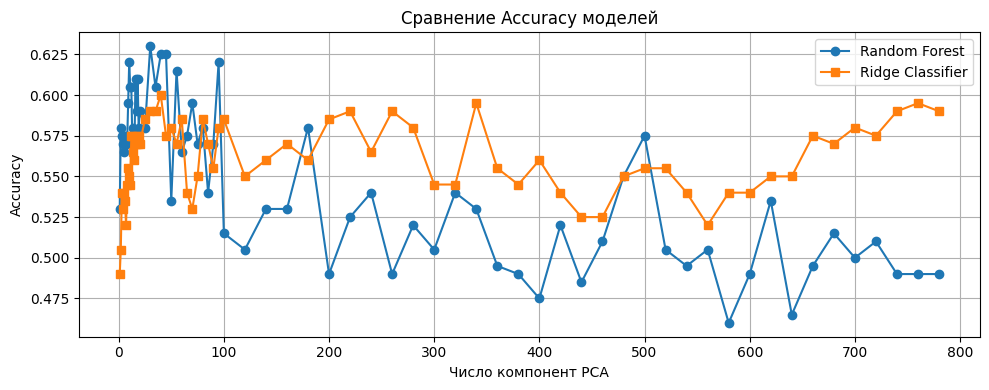

In [58]:
plt.figure(figsize=(10, 4))
plt.plot(components_range, accs_rf, label='Random Forest', marker='o')
plt.plot(components_range, accs_ridge, label='Ridge Classifier', marker='s')
plt.xlabel("Число компонент PCA")
plt.ylabel("Accuracy")
plt.title("Сравнение Accuracy моделей")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

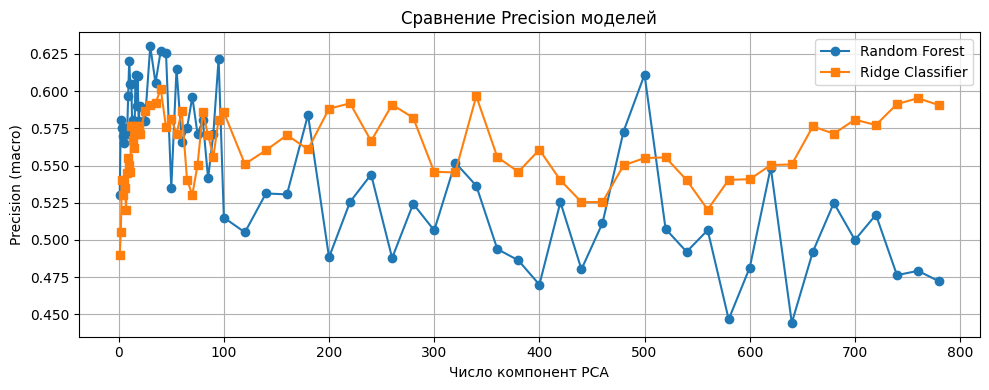

In [59]:
plt.figure(figsize=(10, 4))
plt.plot(components_range, precs_rf, label='Random Forest', marker='o')
plt.plot(components_range, precs_ridge, label='Ridge Classifier', marker='s')
plt.xlabel("Число компонент PCA")
plt.ylabel("Precision (macro)")
plt.title("Сравнение Precision моделей")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

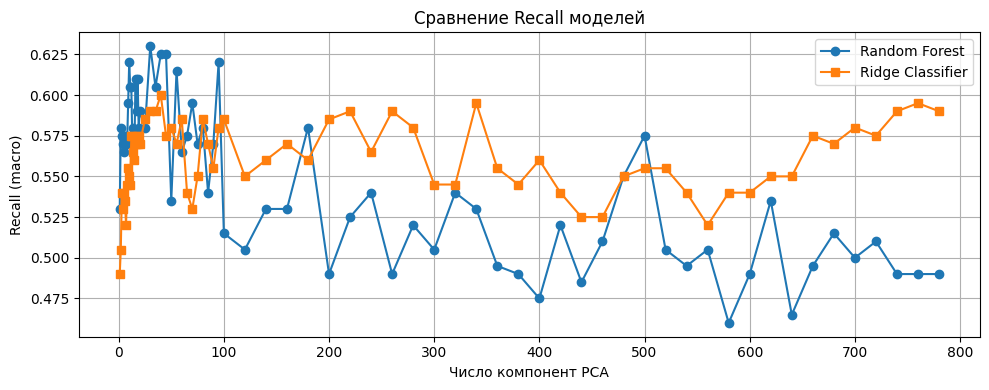

In [60]:
plt.figure(figsize=(10, 4))
plt.plot(components_range, recalls_rf, label='Random Forest', marker='o')
plt.plot(components_range, recalls_ridge, label='Ridge Classifier', marker='s')
plt.xlabel("Число компонент PCA")
plt.ylabel("Recall (macro)")
plt.title("Сравнение Recall моделей")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()